In [1]:
import cv2
import pytesseract
import os
import csv
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.spatial.transform import Rotation as R

In [2]:
def process_video(dataname):
    print(f"\n🚀 processing:{dataname}")
    
    video_path = f'{dataname}.mp4'
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error opening video file")
        return

    # get fps
    fps = cap.get(cv2.CAP_PROP_FPS)
    print(f"🎞️ Frame rate: {fps} fps")

    # open a floder to save frame
    output_folder = f'frames_{dataname}'
    os.makedirs(output_folder, exist_ok=True)

    frame_idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_filename = os.path.join(output_folder, f"frame_{frame_idx:04d}.png")
        crop_frame = frame[108:888, 360:1370]  # crop -> 780 * 1010
        cv2.imwrite(frame_filename, crop_frame)
        frame_idx += 1

    cap.release()
    print(f"✅ Saved {frame_idx} frames to {output_folder}")

In [3]:
def process_timestamps(dataname):
    import os
    import re
    import cv2
    import csv
    import pytesseract

    pytesseract.pytesseract.tesseract_cmd = r"D:\Tesseract OCR\tesseract.exe"

    # Set folders
    input_folder = f'frames_{dataname}'          # Input image folder
    output_csv = f'{dataname}.csv'               # Output CSV file

    # Prepare to store timestamps
    timestamps = []
    last_timestamp = None 

    # Get all image files
    file_list = sorted([f for f in os.listdir(input_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    # Timestamp regex
    timestamp_pattern = re.compile(r'\d{2}[:;]\d{2}[:;]\d{2}[\.,]\d{3}')

    def timestamp_to_seconds(timestamp_str):
        h, m, s_ms = timestamp_str.split(":")
        s, ms = s_ms.split(".")
        return round(int(h) * 3600 + int(m) * 60 + int(s) + int(ms) / 1000, 3)

    for idx, filename in enumerate(file_list):
        img_path = os.path.join(input_folder, filename)
        img = cv2.imread(img_path)

        if img is None:
            print(f"Warning: Cannot read {filename}")
            continue

        # Define timestamp region
        y1, y2, x1, x2 = 0, 90, 40, 340
        timestamp_area = img[y1:y2, x1:x2]
        gray = cv2.cvtColor(timestamp_area, cv2.COLOR_BGR2GRAY)

        # OCR
        custom_config = r'--oem 3 --psm 7'
        timestamp_text = pytesseract.image_to_string(gray, config=custom_config).strip()
        print(f"{filename} -> {timestamp_text}")

        if not timestamp_pattern.fullmatch(timestamp_text):
            print(f"❌ Timestamp format error at {filename}: {timestamp_text}")
            print("🗑️ Deleting this frame and all subsequent frames...")

            # Delete current and subsequent images
            for bad_file in file_list[idx:]:
                bad_path = os.path.join(input_folder, bad_file)
                try:
                    os.remove(bad_path)
                    print(f"Deleted: {bad_file}")
                except Exception as e:
                    print(f"⚠️ Failed to delete {bad_file}: {e}")
            break

        # Clean OCR output
        corrected_timestamp = timestamp_text.replace(';', ':').replace(',', '.')
        total_seconds = timestamp_to_seconds(corrected_timestamp)

        if total_seconds == last_timestamp:
            print(f"🗑️ Duplicate timestamp {corrected_timestamp} at {filename}, deleting...")
            os.remove(img_path)
            continue

        # update last timestamp
        last_timestamp = total_seconds
        timestamps.append([filename, total_seconds])

        # erase timestamp
        img[y1:y2, x1:x2] = 0
        cv2.imwrite(img_path, img)

    # Export CSV
    with open(output_csv, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["Filename", "Timestamp (seconds)"])
        writer.writerows(timestamps)

    print("✅ Done: Duplicates removed, timestamps saved, and images updated.")

In [4]:
def interpolate_sensor_data(dataname):
    data_frame = pd.read_csv(f'{dataname}.csv')
    data_sensor = pd.read_csv(f'linear_position_{dataname}.csv')
    
    data_frame = data_frame.rename(columns={'Timestamp (seconds)': 'Timestamp (s)'})
    interp_columns = ['X (mm)', 'Y (mm)', 'Z (mm)', 'Roll (deg)', 'Pitch (deg)', 'Yaw (deg)']

    # linear interpolation
    for col in interp_columns:
        data_frame[col] = np.interp(
            data_frame['Timestamp (s)'],           # timestamps corresponding to files
            data_sensor['Timestamp (s)'],     # timestamps of sensor
            data_sensor[col]              # data of sensor
        )

    # output csv
    data_frame.to_csv(f'{dataname}_final_data.csv', index = False)
    print(f"✅ {dataname}_final_data.csv is saved successfully!")

In [5]:
def plot_6dof_motion(dataname):
    # Load data
    df = pd.read_csv(f"{dataname}_final_data.csv")
    pos = df[["X (mm)", "Y (mm)", "Z (mm)"]].to_numpy() / 1000
    rpy = df[["Roll (deg)", "Pitch (deg)", "Yaw (deg)"]].to_numpy()
    rotations = R.from_euler('xyz', np.deg2rad(rpy))

    # Initialize plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlim(np.min(pos[:, 0]) - 0.1, np.max(pos[:, 0]) + 0.1)
    ax.set_ylim(np.min(pos[:, 1]) - 0.1, np.max(pos[:, 1]) + 0.1)
    ax.set_zlim(np.min(pos[:, 2]) - 0.1, np.max(pos[:, 2]) + 0.1)
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    ax.set_title('6DOF Motion')

    trajectory, = ax.plot([], [], [], 'k-', lw=1)
    quivers = []

    def update(frame):
        nonlocal quivers
        # Remove previous quivers
        for q in quivers:
            q.remove()
        quivers = []

        # Update trajectory
        trajectory.set_data(pos[:frame+1, 0], pos[:frame+1, 1])
        trajectory.set_3d_properties(pos[:frame+1, 2])

        # Add orientation arrows
        p = pos[frame]
        R_mat = rotations[frame].as_matrix()
        for i, color in enumerate(['r', 'g', 'b']):
            v = R_mat[:, i]
            q = ax.quiver(p[0], p[1], p[2], v[0], v[1], v[2],
                          color=color, length=0.05, normalize=True)
            quivers.append(q)
        return [trajectory] + quivers

    # Create animation
    anim = FuncAnimation(fig, update, frames=len(pos), interval=50, blit=False)

    # Display animation
    plt.tight_layout()
    plt.show()

    # Save as GIF (for MP4, make sure ffmpeg is installed)
    anim.save(f"{dataname}_6dof_motion.gif", writer='pillow', fps=20)


🚀 processing:0513_09
🎞️ Frame rate: 29.083095669202613 fps
✅ Saved 998 frames to frames_0513_09
frame_0000.png -> 13:52:15.976
frame_0001.png -> 13:52:15.976
🗑️ Duplicate timestamp 13:52:15.976 at frame_0001.png, deleting...
frame_0002.png -> 13:52:16.056
frame_0003.png -> 13:52:16.056
🗑️ Duplicate timestamp 13:52:16.056 at frame_0003.png, deleting...
frame_0004.png -> 13:52:16.056
🗑️ Duplicate timestamp 13:52:16.056 at frame_0004.png, deleting...
frame_0005.png -> 13:52:16.056
🗑️ Duplicate timestamp 13:52:16.056 at frame_0005.png, deleting...
frame_0006.png -> 13:52:16.128
frame_0007.png -> 13:52:16.128
🗑️ Duplicate timestamp 13:52:16.128 at frame_0007.png, deleting...
frame_0008.png -> 13:52:16.128
🗑️ Duplicate timestamp 13:52:16.128 at frame_0008.png, deleting...
frame_0009.png -> 13:52:16.128
🗑️ Duplicate timestamp 13:52:16.128 at frame_0009.png, deleting...
frame_0010.png -> 13:52:16.197
frame_0011.png -> 13:52:16.197
🗑️ Duplicate timestamp 13:52:16.197 at frame_0011.png, deletin

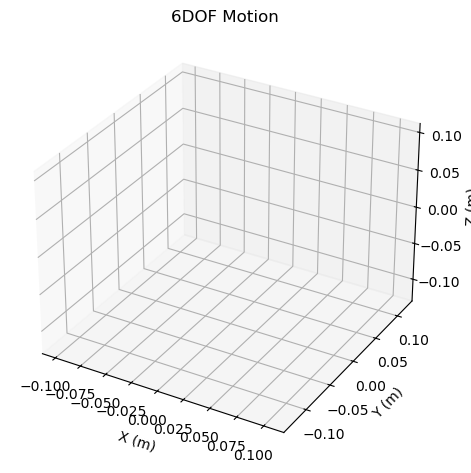


🚀 processing:0513_10
🎞️ Frame rate: 27.026216282355914 fps
✅ Saved 951 frames to frames_0513_10
frame_0000.png -> 13:53:15.040
frame_0001.png -> 13:53:15.112
frame_0002.png -> 13:53:15.112
🗑️ Duplicate timestamp 13:53:15.112 at frame_0002.png, deleting...
frame_0003.png -> 13:53:15.112
🗑️ Duplicate timestamp 13:53:15.112 at frame_0003.png, deleting...
frame_0004.png -> 13:53:15.186
frame_0005.png -> 13:53:15.186
🗑️ Duplicate timestamp 13:53:15.186 at frame_0005.png, deleting...
frame_0006.png -> 13:53:15.186
🗑️ Duplicate timestamp 13:53:15.186 at frame_0006.png, deleting...
frame_0007.png -> 13:53:15.186
🗑️ Duplicate timestamp 13:53:15.186 at frame_0007.png, deleting...
frame_0008.png -> 13:53:15.258
frame_0009.png -> 13:53:15.258
🗑️ Duplicate timestamp 13:53:15.258 at frame_0009.png, deleting...
frame_0010.png -> 13:53:15.258
🗑️ Duplicate timestamp 13:53:15.258 at frame_0010.png, deleting...
frame_0011.png -> 13:53:15.258
🗑️ Duplicate timestamp 13:53:15.258 at frame_0011.png, deletin

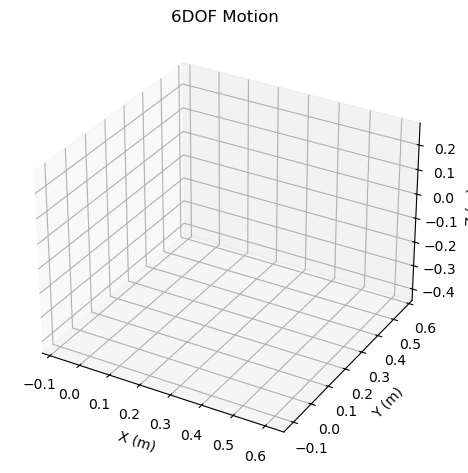


🚀 processing:0513_11
🎞️ Frame rate: 49.03778849823796 fps
✅ Saved 808 frames to frames_0513_11
frame_0000.png -> 14:02:26.864
frame_0001.png -> 14:02:26.864
🗑️ Duplicate timestamp 14:02:26.864 at frame_0001.png, deleting...
frame_0002.png -> 14:02:26.948
frame_0003.png -> 14:02:26.948
🗑️ Duplicate timestamp 14:02:26.948 at frame_0003.png, deleting...
frame_0004.png -> 14:02:26.948
🗑️ Duplicate timestamp 14:02:26.948 at frame_0004.png, deleting...
frame_0005.png -> 14:02:26.948
🗑️ Duplicate timestamp 14:02:26.948 at frame_0005.png, deleting...
frame_0006.png -> 14:02:27.015
frame_0007.png -> 14:02:27.015
🗑️ Duplicate timestamp 14:02:27.015 at frame_0007.png, deleting...
frame_0008.png -> 14:02:27.015
🗑️ Duplicate timestamp 14:02:27.015 at frame_0008.png, deleting...
frame_0009.png -> 14:02:27.015
🗑️ Duplicate timestamp 14:02:27.015 at frame_0009.png, deleting...
frame_0010.png -> 14:02:27.092
frame_0011.png -> 14:02:27.092
🗑️ Duplicate timestamp 14:02:27.092 at frame_0011.png, deleting

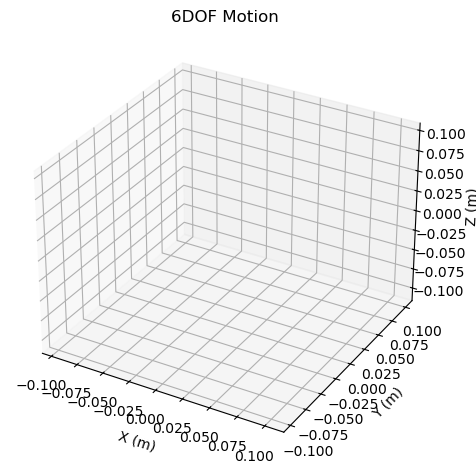


🚀 processing:0513_12
🎞️ Frame rate: 46.15384615384615 fps
✅ Saved 640 frames to frames_0513_12
frame_0000.png -> 14:03:07.846
frame_0001.png -> 14:03:07.846
🗑️ Duplicate timestamp 14:03:07.846 at frame_0001.png, deleting...
frame_0002.png -> 14:03:07.846
🗑️ Duplicate timestamp 14:03:07.846 at frame_0002.png, deleting...
frame_0003.png -> 14:03:07.924
frame_0004.png -> 14:03:07.924
🗑️ Duplicate timestamp 14:03:07.924 at frame_0004.png, deleting...
frame_0005.png -> 14:03:07.924
🗑️ Duplicate timestamp 14:03:07.924 at frame_0005.png, deleting...
frame_0006.png -> 14:03:08.003
frame_0007.png -> 14:03:08.003
🗑️ Duplicate timestamp 14:03:08.003 at frame_0007.png, deleting...
frame_0008.png -> 14:03:08.003
🗑️ Duplicate timestamp 14:03:08.003 at frame_0008.png, deleting...
frame_0009.png -> 14:03:08.003
🗑️ Duplicate timestamp 14:03:08.003 at frame_0009.png, deleting...
frame_0010.png -> 14:03:08.003
🗑️ Duplicate timestamp 14:03:08.003 at frame_0010.png, deleting...
frame_0011.png -> 14:03:08.

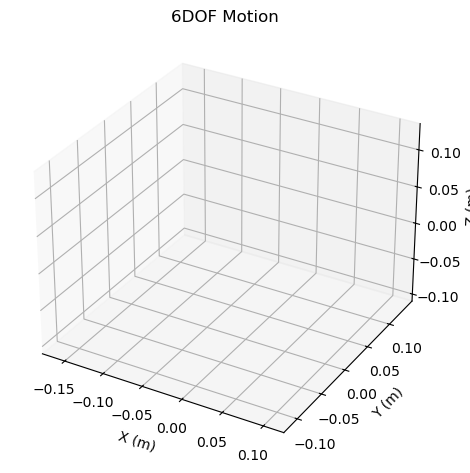


🚀 processing:0513_13
🎞️ Frame rate: 44.00745541834292 fps
✅ Saved 611 frames to frames_0513_13
frame_0000.png -> 14:03:43.258
frame_0001.png -> 14:03:43.258
🗑️ Duplicate timestamp 14:03:43.258 at frame_0001.png, deleting...
frame_0002.png -> 14:03:43.319
frame_0003.png -> 14:03:43.319
🗑️ Duplicate timestamp 14:03:43.319 at frame_0003.png, deleting...
frame_0004.png -> 14:03:43.319
🗑️ Duplicate timestamp 14:03:43.319 at frame_0004.png, deleting...
frame_0005.png -> 14:03:43.319
🗑️ Duplicate timestamp 14:03:43.319 at frame_0005.png, deleting...
frame_0006.png -> 14:03:43.385
frame_0007.png -> 14:03:43.385
🗑️ Duplicate timestamp 14:03:43.385 at frame_0007.png, deleting...
frame_0008.png -> 14:03:43.385
🗑️ Duplicate timestamp 14:03:43.385 at frame_0008.png, deleting...
frame_0009.png -> 14:03:43.385
🗑️ Duplicate timestamp 14:03:43.385 at frame_0009.png, deleting...
frame_0010.png -> 14:03:43.385
🗑️ Duplicate timestamp 14:03:43.385 at frame_0010.png, deleting...
frame_0011.png -> 14:03:43.

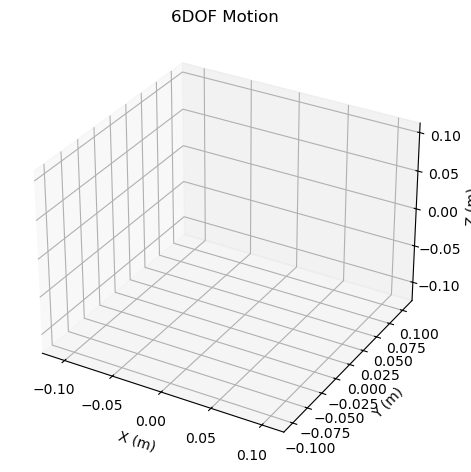


🚀 processing:0513_14
🎞️ Frame rate: 43.008159491940994 fps
✅ Saved 856 frames to frames_0513_14
frame_0000.png -> 14:04:19.687
frame_0001.png -> 14:04:19.764
frame_0002.png -> 14:04:19.764
🗑️ Duplicate timestamp 14:04:19.764 at frame_0002.png, deleting...
frame_0003.png -> 14:04:19.764
🗑️ Duplicate timestamp 14:04:19.764 at frame_0003.png, deleting...
frame_0004.png -> 14:04:19.764
🗑️ Duplicate timestamp 14:04:19.764 at frame_0004.png, deleting...
frame_0005.png -> 14:04:19.764
🗑️ Duplicate timestamp 14:04:19.764 at frame_0005.png, deleting...
frame_0006.png -> 14:04:19.764
🗑️ Duplicate timestamp 14:04:19.764 at frame_0006.png, deleting...
frame_0007.png -> 14:04:19.764
🗑️ Duplicate timestamp 14:04:19.764 at frame_0007.png, deleting...
frame_0008.png -> 14:04:19.764
🗑️ Duplicate timestamp 14:04:19.764 at frame_0008.png, deleting...
frame_0009.png -> 14:04:19.843
frame_0010.png -> 14:04:19.843
🗑️ Duplicate timestamp 14:04:19.843 at frame_0010.png, deleting...
frame_0011.png -> 14:04:19

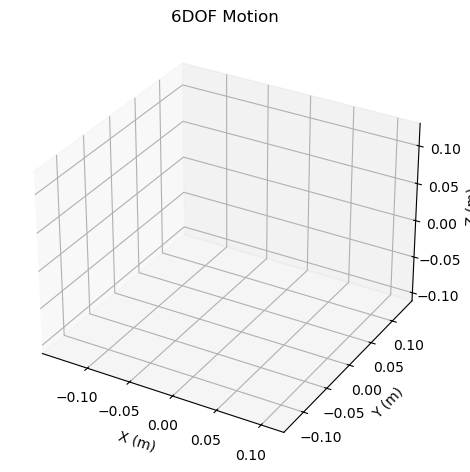


🚀 processing:0513_15
🎞️ Frame rate: 39.1520714536752 fps
✅ Saved 760 frames to frames_0513_15
frame_0000.png -> 14:05:00.292
frame_0001.png -> 14:05:00.292
🗑️ Duplicate timestamp 14:05:00.292 at frame_0001.png, deleting...
frame_0002.png -> 14:05:00.292
🗑️ Duplicate timestamp 14:05:00.292 at frame_0002.png, deleting...
frame_0003.png -> 14:05:00.376
frame_0004.png -> 14:05:00.376
🗑️ Duplicate timestamp 14:05:00.376 at frame_0004.png, deleting...
frame_0005.png -> 14:05:00.376
🗑️ Duplicate timestamp 14:05:00.376 at frame_0005.png, deleting...
frame_0006.png -> 14:05:00.376
🗑️ Duplicate timestamp 14:05:00.376 at frame_0006.png, deleting...
frame_0007.png -> 14:05:00.376
🗑️ Duplicate timestamp 14:05:00.376 at frame_0007.png, deleting...
frame_0008.png -> 14:05:00.441
frame_0009.png -> 14:05:00.441
🗑️ Duplicate timestamp 14:05:00.441 at frame_0009.png, deleting...
frame_0010.png -> 14:05:00.441
🗑️ Duplicate timestamp 14:05:00.441 at frame_0010.png, deleting...
frame_0011.png -> 14:05:00.5

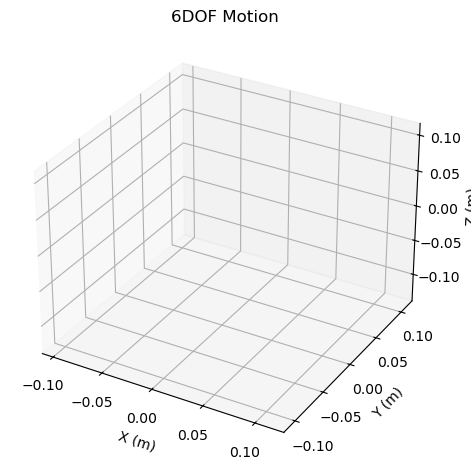


🚀 processing:0513_16
🎞️ Frame rate: 48.758991938769285 fps
✅ Saved 1270 frames to frames_0513_16
frame_0000.png -> 14:09:29.807
frame_0001.png -> 14:09:29.807
🗑️ Duplicate timestamp 14:09:29.807 at frame_0001.png, deleting...
frame_0002.png -> 14:09:29.807
🗑️ Duplicate timestamp 14:09:29.807 at frame_0002.png, deleting...
frame_0003.png -> 14:09:29.871
frame_0004.png -> 14:09:29.871
🗑️ Duplicate timestamp 14:09:29.871 at frame_0004.png, deleting...
frame_0005.png -> 14:09:29.871
🗑️ Duplicate timestamp 14:09:29.871 at frame_0005.png, deleting...
frame_0006.png -> 14:09:29.871
🗑️ Duplicate timestamp 14:09:29.871 at frame_0006.png, deleting...
frame_0007.png -> 14:09:29.945
frame_0008.png -> 14:09:29.945
🗑️ Duplicate timestamp 14:09:29.945 at frame_0008.png, deleting...
frame_0009.png -> 14:09:29.945
🗑️ Duplicate timestamp 14:09:29.945 at frame_0009.png, deleting...
frame_0010.png -> 14:09:29.945
🗑️ Duplicate timestamp 14:09:29.945 at frame_0010.png, deleting...
frame_0011.png -> 14:09:2

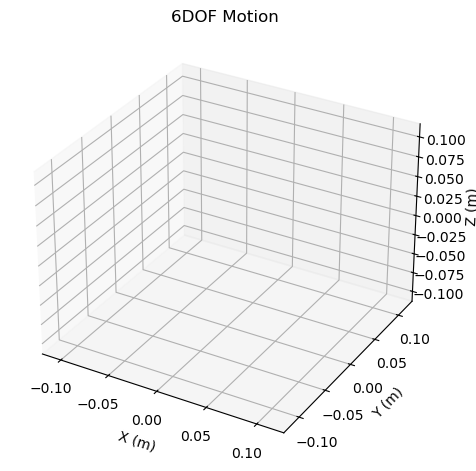


🚀 processing:0513_17
🎞️ Frame rate: 45.99018339229561 fps
✅ Saved 2589 frames to frames_0513_17
frame_0000.png -> 15:27:03.704
frame_0001.png -> 15:27:03.788
frame_0002.png -> 15:27:03.788
🗑️ Duplicate timestamp 15:27:03.788 at frame_0002.png, deleting...
frame_0003.png -> 15:27:03.788
🗑️ Duplicate timestamp 15:27:03.788 at frame_0003.png, deleting...
frame_0004.png -> 15:27:03.788
🗑️ Duplicate timestamp 15:27:03.788 at frame_0004.png, deleting...
frame_0005.png -> 15:27:03.788
🗑️ Duplicate timestamp 15:27:03.788 at frame_0005.png, deleting...
frame_0006.png -> 15:27:03.857
frame_0007.png -> 15:27:03.857
🗑️ Duplicate timestamp 15:27:03.857 at frame_0007.png, deleting...
frame_0008.png -> 15:27:03.857
🗑️ Duplicate timestamp 15:27:03.857 at frame_0008.png, deleting...
frame_0009.png -> 15:27:03.857
🗑️ Duplicate timestamp 15:27:03.857 at frame_0009.png, deleting...
frame_0010.png -> 15:27:03.925
frame_0011.png -> 15:27:03.925
🗑️ Duplicate timestamp 15:27:03.925 at frame_0011.png, deletin

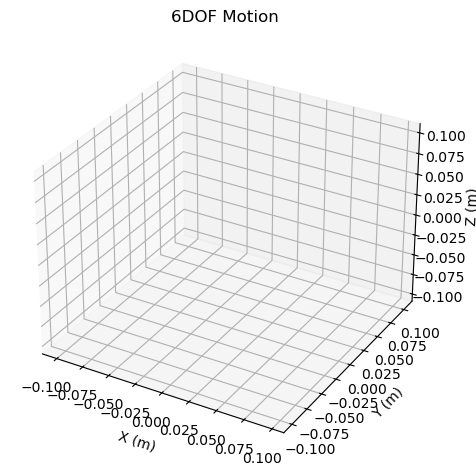


🚀 processing:0513_18
🎞️ Frame rate: 48.86568678443233 fps
✅ Saved 761 frames to frames_0513_18
frame_0000.png -> 15:28:33.076
frame_0001.png -> 15:28:33.076
🗑️ Duplicate timestamp 15:28:33.076 at frame_0001.png, deleting...
frame_0002.png -> 15:28:33.119
frame_0003.png -> 15:28:33.119
🗑️ Duplicate timestamp 15:28:33.119 at frame_0003.png, deleting...
frame_0004.png -> 15:28:33.169
frame_0005.png -> 15:28:33.200
frame_0006.png -> 15:28:33.200
🗑️ Duplicate timestamp 15:28:33.200 at frame_0006.png, deleting...
frame_0007.png -> 15:28:33.200
🗑️ Duplicate timestamp 15:28:33.200 at frame_0007.png, deleting...
frame_0008.png -> 15:28:33.243
frame_0009.png -> 15:28:33.243
🗑️ Duplicate timestamp 15:28:33.243 at frame_0009.png, deleting...
frame_0010.png -> 15:28:33.243
🗑️ Duplicate timestamp 15:28:33.243 at frame_0010.png, deleting...
frame_0011.png -> 15:28:33.293
frame_0012.png -> 15:28:33.293
🗑️ Duplicate timestamp 15:28:33.293 at frame_0012.png, deleting...
frame_0013.png -> 15:28:33.338
f

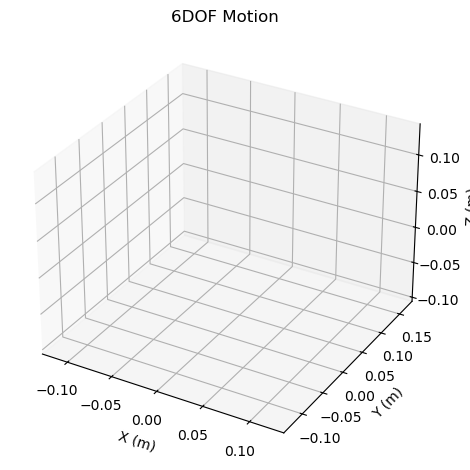


🚀 processing:0513_19
🎞️ Frame rate: 46.25212915487594 fps
✅ Saved 1657 frames to frames_0513_19
frame_0000.png -> 15:29:12.001
frame_0001.png -> 15:29:12.069
frame_0002.png -> 15:29:12.069
🗑️ Duplicate timestamp 15:29:12.069 at frame_0002.png, deleting...
frame_0003.png -> 15:29:12.069
🗑️ Duplicate timestamp 15:29:12.069 at frame_0003.png, deleting...
frame_0004.png -> 15:29:12.105
frame_0005.png -> 15:29:12.105
🗑️ Duplicate timestamp 15:29:12.105 at frame_0005.png, deleting...
frame_0006.png -> 15:29:12.143
frame_0007.png -> 15:29:12.143
🗑️ Duplicate timestamp 15:29:12.143 at frame_0007.png, deleting...
frame_0008.png -> 15:29:12.178
frame_0009.png -> 15:29:12.178
🗑️ Duplicate timestamp 15:29:12.178 at frame_0009.png, deleting...
frame_0010.png -> 15:29:12.178
🗑️ Duplicate timestamp 15:29:12.178 at frame_0010.png, deleting...
frame_0011.png -> 15:29:12.215
frame_0012.png -> 15:29:12.215
🗑️ Duplicate timestamp 15:29:12.215 at frame_0012.png, deleting...
frame_0013.png -> 15:29:12.266


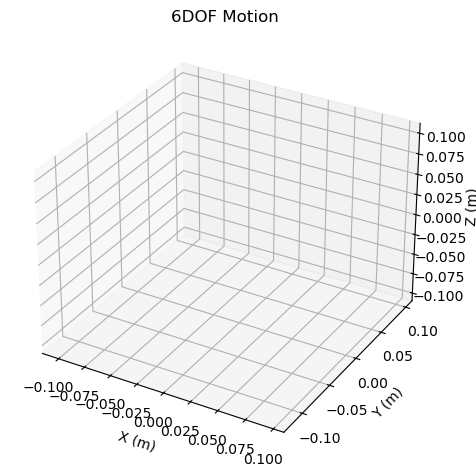


🚀 processing:0513_20
🎞️ Frame rate: 38.22208292034624 fps
✅ Saved 626 frames to frames_0513_20
frame_0000.png -> 15:30:14.968
frame_0001.png -> 15:30:15.045
frame_0002.png -> 15:30:15.045
🗑️ Duplicate timestamp 15:30:15.045 at frame_0002.png, deleting...
frame_0003.png -> 15:30:15.045
🗑️ Duplicate timestamp 15:30:15.045 at frame_0003.png, deleting...
frame_0004.png -> 15:30:15.084
frame_0005.png -> 15:30:15.084
🗑️ Duplicate timestamp 15:30:15.084 at frame_0005.png, deleting...
frame_0006.png -> 15:30:15.084
🗑️ Duplicate timestamp 15:30:15.084 at frame_0006.png, deleting...
frame_0007.png -> 15:30:15.123
frame_0008.png -> 15:30:15.123
🗑️ Duplicate timestamp 15:30:15.123 at frame_0008.png, deleting...
frame_0009.png -> 15:30:15.174
frame_0010.png -> 15:30:15.174
🗑️ Duplicate timestamp 15:30:15.174 at frame_0010.png, deleting...
frame_0011.png -> 15:30:15.174
🗑️ Duplicate timestamp 15:30:15.174 at frame_0011.png, deleting...
frame_0012.png -> 15:30:15.217
frame_0013.png -> 15:30:15.262
f

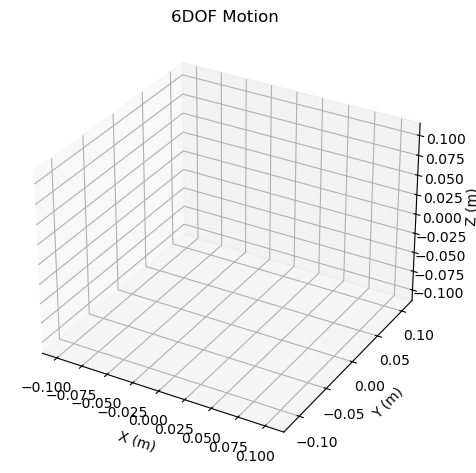


🚀 processing:0513_21
🎞️ Frame rate: 35.479050252317535 fps
✅ Saved 3037 frames to frames_0513_21
frame_0000.png -> 15:31:02.964
frame_0001.png -> 15:31:02.964
🗑️ Duplicate timestamp 15:31:02.964 at frame_0001.png, deleting...
frame_0002.png -> 15:31:03.010
frame_0003.png -> 15:31:03.010
🗑️ Duplicate timestamp 15:31:03.010 at frame_0003.png, deleting...
frame_0004.png -> 15:31:03.010
🗑️ Duplicate timestamp 15:31:03.010 at frame_0004.png, deleting...
frame_0005.png -> 15:31:03.010
🗑️ Duplicate timestamp 15:31:03.010 at frame_0005.png, deleting...
frame_0006.png -> 15:31:03.088
frame_0007.png -> 15:31:03.088
🗑️ Duplicate timestamp 15:31:03.088 at frame_0007.png, deleting...
frame_0008.png -> 15:31:03.088
🗑️ Duplicate timestamp 15:31:03.088 at frame_0008.png, deleting...
frame_0009.png -> 15:31:03.088
🗑️ Duplicate timestamp 15:31:03.088 at frame_0009.png, deleting...
frame_0010.png -> 15:31:03.128
frame_0011.png -> 15:31:03.128
🗑️ Duplicate timestamp 15:31:03.128 at frame_0011.png, deleti

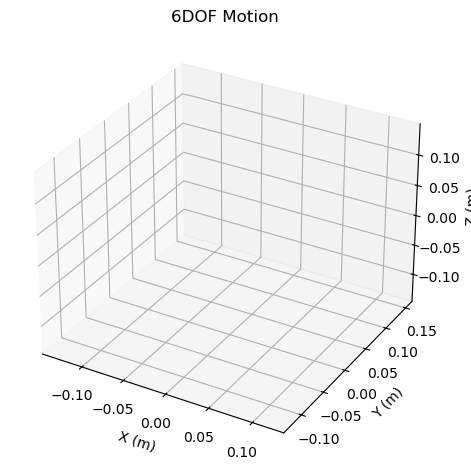


🚀 processing:0513_22
🎞️ Frame rate: 45.41373972250422 fps
✅ Saved 928 frames to frames_0513_22
frame_0000.png -> 15:37:23.222
frame_0001.png -> 15:37:23.287
frame_0002.png -> 15:37:23.287
🗑️ Duplicate timestamp 15:37:23.287 at frame_0002.png, deleting...
frame_0003.png -> 15:37:23.287
🗑️ Duplicate timestamp 15:37:23.287 at frame_0003.png, deleting...
frame_0004.png -> 15:37:23.345
frame_0005.png -> 15:37:23.345
🗑️ Duplicate timestamp 15:37:23.345 at frame_0005.png, deleting...
frame_0006.png -> 15:37:23.345
🗑️ Duplicate timestamp 15:37:23.345 at frame_0006.png, deleting...
frame_0007.png -> 15:37:23.403
frame_0008.png -> 15:37:23.403
🗑️ Duplicate timestamp 15:37:23.403 at frame_0008.png, deleting...
frame_0009.png -> 15:37:23.403
🗑️ Duplicate timestamp 15:37:23.403 at frame_0009.png, deleting...
frame_0010.png -> 15:37:23.403
🗑️ Duplicate timestamp 15:37:23.403 at frame_0010.png, deleting...
frame_0011.png -> 15:37:23.467
frame_0012.png -> 15:37:23.467
🗑️ Duplicate timestamp 15:37:23.

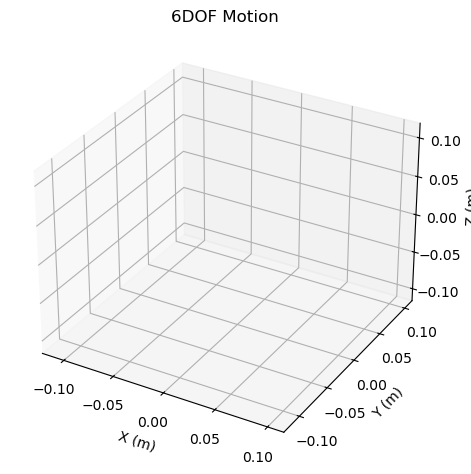


🚀 processing:0513_23
🎞️ Frame rate: 46.133741651046755 fps
✅ Saved 466 frames to frames_0513_23
frame_0000.png -> 15:38:08.001
frame_0001.png -> 15:38:08.072
frame_0002.png -> 15:38:08.072
🗑️ Duplicate timestamp 15:38:08.072 at frame_0002.png, deleting...
frame_0003.png -> 15:38:08.072
🗑️ Duplicate timestamp 15:38:08.072 at frame_0003.png, deleting...
frame_0004.png -> 15:38:08.072
🗑️ Duplicate timestamp 15:38:08.072 at frame_0004.png, deleting...
frame_0005.png -> 15:38:08.135
frame_0006.png -> 15:38:08.135
🗑️ Duplicate timestamp 15:38:08.135 at frame_0006.png, deleting...
frame_0007.png -> 15:38:08.185
frame_0008.png -> 15:38:08.185
🗑️ Duplicate timestamp 15:38:08.185 at frame_0008.png, deleting...
frame_0009.png -> 15:38:08.185
🗑️ Duplicate timestamp 15:38:08.185 at frame_0009.png, deleting...
frame_0010.png -> 15:38:08.245
frame_0011.png -> 15:38:08.245
🗑️ Duplicate timestamp 15:38:08.245 at frame_0011.png, deleting...
frame_0012.png -> 15:38:08.245
🗑️ Duplicate timestamp 15:38:08

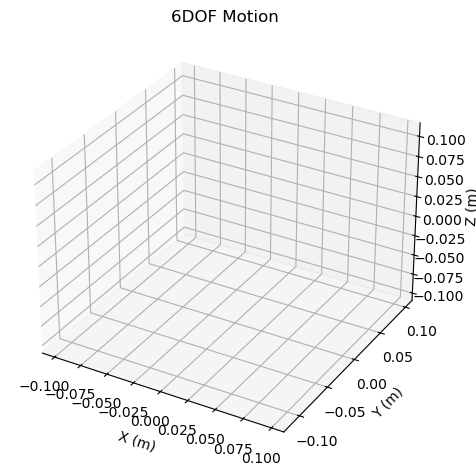


🚀 processing:0513_24
🎞️ Frame rate: 44.93562759386671 fps
✅ Saved 1060 frames to frames_0513_24
frame_0000.png -> 15:38:40.781
frame_0001.png -> 15:38:40.781
🗑️ Duplicate timestamp 15:38:40.781 at frame_0001.png, deleting...
frame_0002.png -> 15:38:40.844
frame_0003.png -> 15:38:40.844
🗑️ Duplicate timestamp 15:38:40.844 at frame_0003.png, deleting...
frame_0004.png -> 15:38:40.844
🗑️ Duplicate timestamp 15:38:40.844 at frame_0004.png, deleting...
frame_0005.png -> 15:38:40.844
🗑️ Duplicate timestamp 15:38:40.844 at frame_0005.png, deleting...
frame_0006.png -> 15:38:40.915
frame_0007.png -> 15:38:40.915
🗑️ Duplicate timestamp 15:38:40.915 at frame_0007.png, deleting...
frame_0008.png -> 15:38:40.915
🗑️ Duplicate timestamp 15:38:40.915 at frame_0008.png, deleting...
frame_0009.png -> 15:38:40.915
🗑️ Duplicate timestamp 15:38:40.915 at frame_0009.png, deleting...
frame_0010.png -> 15:38:40.971
frame_0011.png -> 15:38:40.971
🗑️ Duplicate timestamp 15:38:40.971 at frame_0011.png, deletin

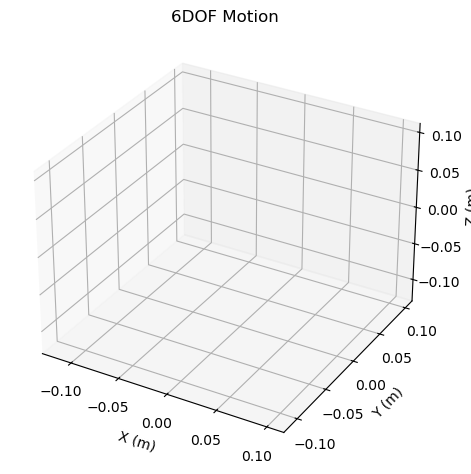


🚀 processing:0513_25
🎞️ Frame rate: 38.59301183860129 fps
✅ Saved 528 frames to frames_0513_25
frame_0000.png -> 15:40:10.809
frame_0001.png -> 15:40:10.869
frame_0002.png -> 15:40:10.869
🗑️ Duplicate timestamp 15:40:10.869 at frame_0002.png, deleting...
frame_0003.png -> 15:40:10.869
🗑️ Duplicate timestamp 15:40:10.869 at frame_0003.png, deleting...
frame_0004.png -> 15:40:10.937
frame_0005.png -> 15:40:10.937
🗑️ Duplicate timestamp 15:40:10.937 at frame_0005.png, deleting...
frame_0006.png -> 15:40:10.937
🗑️ Duplicate timestamp 15:40:10.937 at frame_0006.png, deleting...
frame_0007.png -> 15:40:10.988
frame_0008.png -> 15:40:10.988
🗑️ Duplicate timestamp 15:40:10.988 at frame_0008.png, deleting...
frame_0009.png -> 15:40:10.988
🗑️ Duplicate timestamp 15:40:10.988 at frame_0009.png, deleting...
frame_0010.png -> 15:40:11.045
frame_0011.png -> 15:40:11.045
🗑️ Duplicate timestamp 15:40:11.045 at frame_0011.png, deleting...
frame_0012.png -> 15:40:11.045
🗑️ Duplicate timestamp 15:40:11.

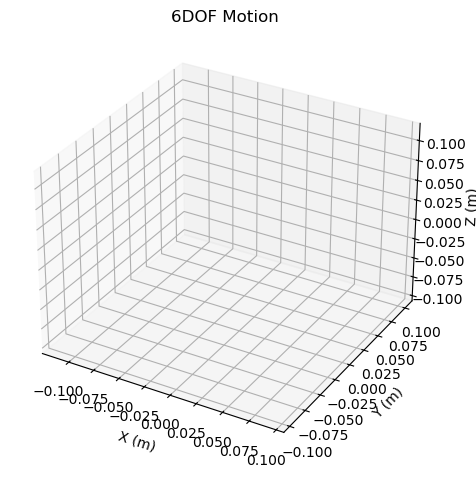


🚀 processing:0513_26
🎞️ Frame rate: 26.98795484962501 fps
✅ Saved 570 frames to frames_0513_26
frame_0000.png -> 15:40:47.644
frame_0001.png -> 15:40:47.644
🗑️ Duplicate timestamp 15:40:47.644 at frame_0001.png, deleting...
frame_0002.png -> 15:40:47.712
frame_0003.png -> 15:40:47.712
🗑️ Duplicate timestamp 15:40:47.712 at frame_0003.png, deleting...
frame_0004.png -> 15:40:47.712
🗑️ Duplicate timestamp 15:40:47.712 at frame_0004.png, deleting...
frame_0005.png -> 15:40:47.712
🗑️ Duplicate timestamp 15:40:47.712 at frame_0005.png, deleting...
frame_0006.png -> 15:40:47.712
🗑️ Duplicate timestamp 15:40:47.712 at frame_0006.png, deleting...
frame_0007.png -> 15:40:47.786
frame_0008.png -> 15:40:47.786
🗑️ Duplicate timestamp 15:40:47.786 at frame_0008.png, deleting...
frame_0009.png -> 15:40:47.786
🗑️ Duplicate timestamp 15:40:47.786 at frame_0009.png, deleting...
frame_0010.png -> 15:40:47.786
🗑️ Duplicate timestamp 15:40:47.786 at frame_0010.png, deleting...
frame_0011.png -> 15:40:47.

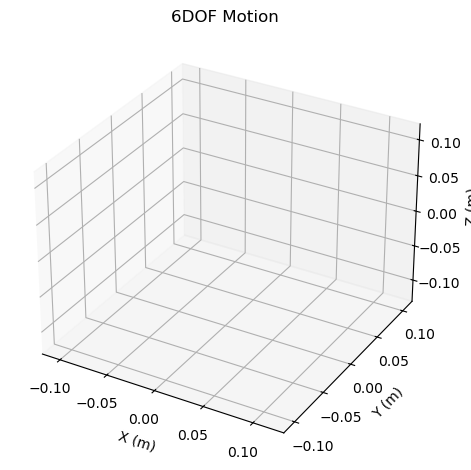

In [7]:
for i in range(9, 27): # numbers of dataname change here
    dataname = f'0513_{i:02d}' # date part of dataname change here 
    process_video(dataname)
    process_timestamps(dataname)
    interpolate_sensor_data(dataname)
    plot_6dof_motion(dataname)